In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#import decisiontreeclassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from IPython.display import SVG
#from graphviz import Source
from IPython.display import display
#import logisticregression classifier
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
#import knn classifier
from sklearn.neighbors import KNeighborsClassifier

#for validating your classification model
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, GridSearchCV 
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

# feature selection
from sklearn.feature_selection import RFE
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

#pip install scikit-plot #(optional)
#import scikitplot as skplt

import warnings
warnings.filterwarnings("ignore")

In [57]:
import pandas as pd
import numpy as np

data = pd.read_csv(r"C:\Users\natec\OneDrive\Stuff + model\merged_file.csv")



In [58]:
data = data[data["PitchCall"].isin(["BallCalled", "StrikeCalled"])]

In [59]:
data.shape

(52898, 167)

In [60]:
data['SameHand'] = (data['PitcherThrows'] == data['BatterSide']).astype(int)


In [61]:
features = ["PitchCall",'VertBreak',"HorzBreak",'PlateLocHeight','PlateLocSide','PitcherThrows','BatterSide']

df = data[features]



In [62]:
df.shape

(52898, 7)

In [63]:
df.dropna(axis=0, how='any', inplace=True)


In [64]:
df['PitchCall'].value_counts()


PitchCall
BallCalled      34715
StrikeCalled    16956
Name: count, dtype: int64

# Creating Model

In [65]:
#encode strike as 1 and ball as 0
# set y variable
y = (df['PitchCall'] == 'StrikeCalled').astype(int)

y.value_counts()


PitchCall
0    34715
1    16956
Name: count, dtype: int64

In [66]:
# setting X variable

X = df[['PlateLocHeight', 'PlateLocSide', 'VertBreak', 'HorzBreak']]#,'PitcherThrows','BatterSide']]

print(X.columns)

Index(['PlateLocHeight', 'PlateLocSide', 'VertBreak', 'HorzBreak'], dtype='object')


In [67]:
#X = pd.get_dummies(X, drop_first=True)

In [68]:
X.columns

Index(['PlateLocHeight', 'PlateLocSide', 'VertBreak', 'HorzBreak'], dtype='object')

In [69]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [70]:
from xgboost import XGBClassifier

model = XGBClassifier(
    n_estimators=400,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    eval_metric='auc',
    random_state=42
)

model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=400,
              n_jobs=None, num_parallel_tree=None, ...)

In [71]:
from sklearn.metrics import roc_auc_score

strike_probs = model.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, strike_probs)


np.float64(0.9643813523735234)

In [72]:
import pandas as pd

pd.Series(
    model.feature_importances_,
    index=X.columns
).sort_values(ascending=False)


PlateLocHeight    0.531479
PlateLocSide      0.429065
VertBreak         0.020798
HorzBreak         0.018658
dtype: float32

In [73]:
# Predict strike probabilities for the full dataset
k_probs = model.predict_proba(X)[:, 1]

# Add them back into your DataFrame
df['strike_prob'] = k_probs



# Model Evaluation

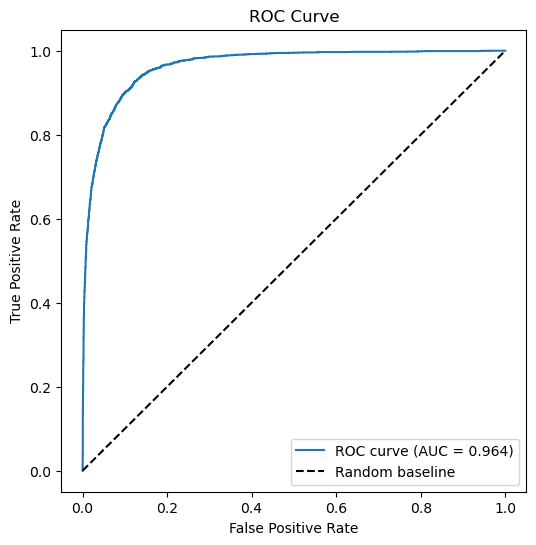

ROC–AUC score: 0.964


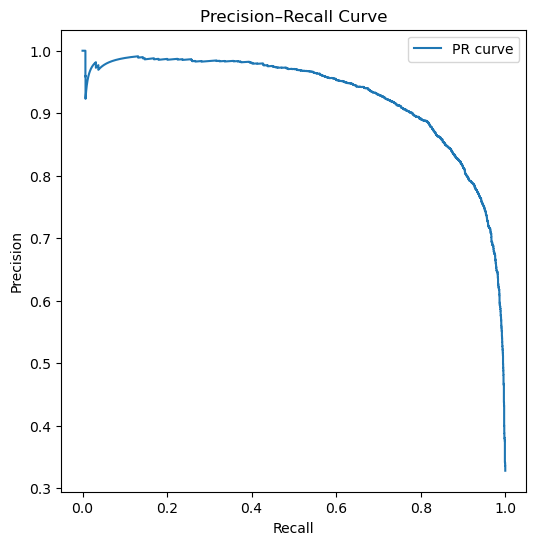

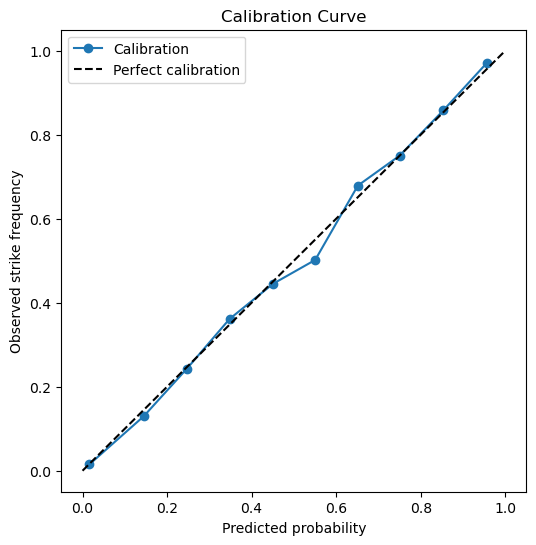

In [74]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve
from sklearn.calibration import calibration_curve

# --- ROC–AUC ---
roc_auc = roc_auc_score(y_test, strike_probs)
fpr, tpr, _ = roc_curve(y_test, strike_probs)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random baseline')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

print(f"ROC–AUC score: {roc_auc:.3f}")

# --- Precision–Recall ---
precision, recall, _ = precision_recall_curve(y_test, strike_probs)

plt.figure(figsize=(6, 6))
plt.plot(recall, precision, label='PR curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve')
plt.legend()
plt.show()

# --- Calibration curve ---
prob_true, prob_pred = calibration_curve(y_test, strike_probs, n_bins=10)

plt.figure(figsize=(6, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Calibration')
plt.plot([0, 1], [0, 1], 'k--', label='Perfect calibration')
plt.xlabel('Predicted probability')
plt.ylabel('Observed strike frequency')
plt.title('Calibration Curve')
plt.legend()
plt.show()

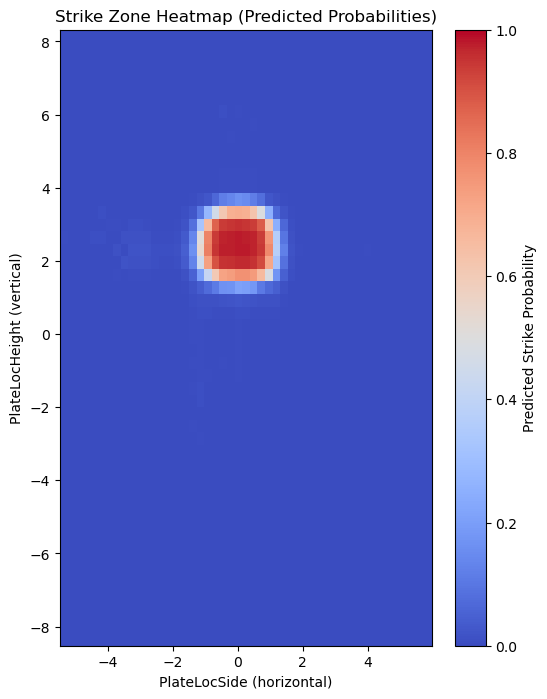

In [75]:
bins_x = np.linspace(df['PlateLocSide'].min(), df['PlateLocSide'].max(), 50)
bins_z = np.linspace(df['PlateLocHeight'].min(), df['PlateLocHeight'].max(), 50)

# 2D histogram weighted by predicted strike probability
heatmap, xedges, zedges = np.histogram2d(
    df['PlateLocSide'], df['PlateLocHeight'],
    bins=[bins_x, bins_z],
    weights=df['strike_prob']
)
counts, _, _ = np.histogram2d(
    df['PlateLocSide'], df['PlateLocHeight'],
    bins=[bins_x, bins_z]
)

# Average probability per bin
avg_prob = np.divide(heatmap, counts, out=np.zeros_like(heatmap), where=counts>0)

plt.figure(figsize=(6, 8))
plt.imshow(
    avg_prob.T, origin='lower',
    extent=[bins_x.min(), bins_x.max(), bins_z.min(), bins_z.max()],
    aspect='auto', cmap='coolwarm', vmin=0, vmax=1
)
plt.colorbar(label='Predicted Strike Probability')
plt.xlabel('PlateLocSide (horizontal)')
plt.ylabel('PlateLocHeight (vertical)')
plt.title('Strike Zone Heatmap (Predicted Probabilities)')
plt.show()


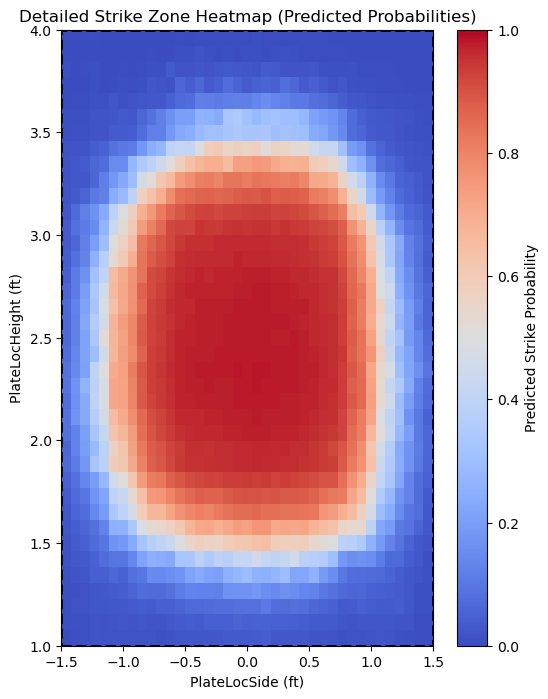

In [76]:
x_min, x_max = -1.5, 1.5
z_min, z_max = 1, 4

# Use finer bins for more detail
bins_x = np.linspace(x_min, x_max, 40)
bins_z = np.linspace(z_min, z_max, 40)

# 2D histogram weighted by predicted strike probability
heatmap, xedges, zedges = np.histogram2d(
    df['PlateLocSide'], df['PlateLocHeight'],
    bins=[bins_x, bins_z],
    weights=df['strike_prob']
)
counts, _, _ = np.histogram2d(
    df['PlateLocSide'], df['PlateLocHeight'],
    bins=[bins_x, bins_z]
)

# Average probability per bin
avg_prob = np.divide(heatmap, counts, out=np.zeros_like(heatmap), where=counts>0)

plt.figure(figsize=(6, 8))
plt.imshow(
    avg_prob.T, origin='lower',
    extent=[x_min, x_max, z_min, z_max],
    aspect='auto', cmap='coolwarm', vmin=0, vmax=1
)
plt.colorbar(label='Predicted Strike Probability')
plt.xlabel('PlateLocSide (ft)')
plt.ylabel('PlateLocHeight (ft)')
plt.title('Detailed Strike Zone Heatmap (Predicted Probabilities)')

# Overlay strike zone box
plt.plot([x_min, x_max, x_max, x_min, x_min],
         [z_min, z_min, z_max, z_max, z_min],
         color='black', linestyle='--', linewidth=2)

plt.show()


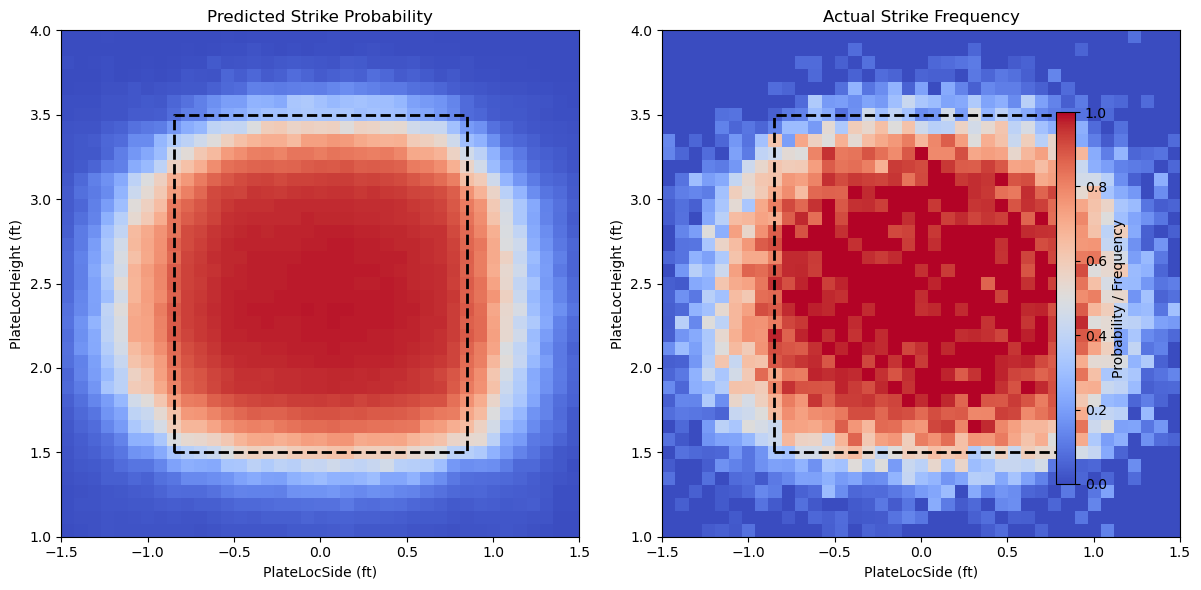

In [77]:

import matplotlib.pyplot as plt
import numpy as np

# Define strike zone bounds
x_min, x_max = -1.5, 1.5   # PlateLocSide range
z_min, z_max = 1.0, 4.0    # PlateLocHeight range

bins_x = np.linspace(x_min, x_max, 40)
bins_z = np.linspace(z_min, z_max, 40)

# Predicted strike probability heatmap
heatmap_pred, _, _ = np.histogram2d(
    df['PlateLocSide'], df['PlateLocHeight'],
    bins=[bins_x, bins_z], weights=df['strike_prob']
)
counts_pred, _, _ = np.histogram2d(
    df['PlateLocSide'], df['PlateLocHeight'],
    bins=[bins_x, bins_z]
)
avg_pred = np.divide(heatmap_pred, counts_pred, out=np.full_like(heatmap_pred, np.nan), where=counts_pred>0)

# Actual strike frequency heatmap (using y_true: 1=strike, 0=ball)
heatmap_actual, _, _ = np.histogram2d(
    df['PlateLocSide'], df['PlateLocHeight'],
    bins=[bins_x, bins_z], weights=y
)
counts_actual, _, _ = np.histogram2d(
    df['PlateLocSide'], df['PlateLocHeight'],
    bins=[bins_x, bins_z]
)
avg_actual = np.divide(heatmap_actual, counts_actual, out=np.full_like(heatmap_actual, np.nan), where=counts_actual>0)

# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Predicted
im1 = axes[0].imshow(avg_pred.T, origin='lower',
    extent=[x_min, x_max, z_min, z_max],
    aspect='auto', cmap='coolwarm', vmin=0, vmax=1)
axes[0].set_title('Predicted Strike Probability')
axes[0].set_xlabel('PlateLocSide (ft)')
axes[0].set_ylabel('PlateLocHeight (ft)')
axes[0].plot([-0.85, 0.85, 0.85, -0.85, -0.85],
             [1.5, 1.5, 3.5, 3.5, 1.5],
             color='black', linestyle='--', linewidth=2)

# Actual
im2 = axes[1].imshow(avg_actual.T, origin='lower',
    extent=[x_min, x_max, z_min, z_max],
    aspect='auto', cmap='coolwarm', vmin=0, vmax=1)
axes[1].set_title('Actual Strike Frequency')
axes[1].set_xlabel('PlateLocSide (ft)')
axes[1].set_ylabel('PlateLocHeight (ft)')
axes[1].plot([-0.85, 0.85, 0.85, -0.85, -0.85],
             [1.5, 1.5, 3.5, 3.5, 1.5],
             color='black', linestyle='--', linewidth=2)

fig.colorbar(im1, ax=axes, orientation='vertical', fraction=0.02, pad=0.04, label='Probability / Frequency')
plt.tight_layout()
plt.show()




# Exporting Model

In [78]:
import joblib

joblib.dump(model, 'Strike_Probability_model.pkl')
joblib.dump(X.columns.tolist(), 'Strike_Probability_features.pkl')


['Strike_Probability_features.pkl']